In [7]:
import os
import sys
import numpy as np

import matplotlib.pyplot as pl
%matplotlib inline

In [ ]:
# Following https://www.astroml.org/user_guide/correlation_functions.html

In [17]:
from astroML.correlation import two_point
np.random.seed(0)
X = np.random.random((5000, 2))
print(X.shape)

(5000, 2)


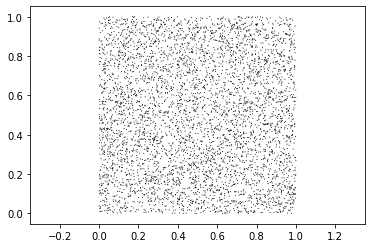

In [18]:
pl.scatter(X[:,0],X[:,1],s=1,edgecolor='None',c='k')
pl.axis('equal');

In [20]:
two_point?

Signature: two_point(data, bins, method='standard', data_R=None, random_state=None)
Docstring:
Two-point correlation function

Parameters
----------
data : array_like
    input data, shape = [n_samples, n_features]
bins : array_like
    bins within which to compute the 2-point correlation.
    shape = Nbins + 1
method : string
    "standard" or "landy-szalay".
data_R : array_like (optional)
    if specified, use this as the random comparison sample
random_state : integer, np.random.RandomState, or None
    specify the random state to use for generating background

Returns
-------
corr : ndarray
    the estimate of the correlation function within each bin
    shape = Nbins
File:      /usr/local/Caskroom/miniconda/base/envs/cosmo/lib/python3.6/site-packages/astroML/correlation.py
Type:      function


In [19]:
bins = np.linspace(0, 1, 20)
corr = two_point(X, bins)
np.allclose(corr, 0, atol=0.02)

True

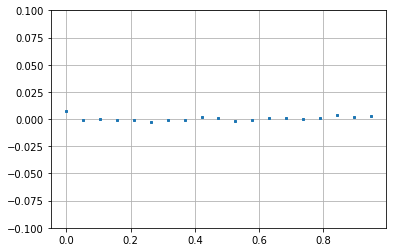

In [54]:
pl.plot(bins[:-1],corr,marker='s',ms=2,ls='')
pl.ylim(-0.1,0.1)
pl.grid()

In [28]:
from astroML.correlation import bootstrap_two_point
corr, dcorr = bootstrap_two_point(X, bins, Nbootstrap=5)
np.allclose(corr, 0, atol=2 * dcorr)

True

In [29]:
bootstrap_two_point?

Signature:
bootstrap_two_point(
    data,
    bins,
    Nbootstrap=10,
    method='standard',
    return_bootstraps=False,
    random_state=None,
)
Docstring:
Bootstrapped two-point correlation function

Parameters
----------
data : array_like
    input data, shape = [n_samples, n_features]
bins : array_like
    bins within which to compute the 2-point correlation.
    shape = Nbins + 1
Nbootstrap : integer
    number of bootstrap resamples to perform (default = 10)
method : string
    "standard" or "landy-szalay".
return_bootstraps: bool
    if True, return full bootstrapped samples
random_state : integer, np.random.RandomState, or None
    specify the random state to use for generating background

Returns
-------
corr, corr_err : ndarrays
    the estimate of the correlation function and the bootstrap
    error within each bin. shape = Nbins
File:      /usr/local/Caskroom/miniconda/base/envs/cosmo/lib/python3.6/site-packages/astroML/correlation.py
Type:      function


In [46]:
from astroML.correlation import bootstrap_two_point
corr, dcorr = bootstrap_two_point(X, bins, Nbootstrap=10)
np.allclose(corr, 0, atol=2 * dcorr)

True

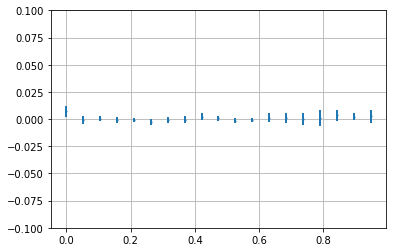

In [51]:
pl.errorbar(bins[:-1],corr,yerr=dcorr,elinewidth=2,marker='s',ms=1,ls='')
pl.ylim(-0.1,0.1)
pl.grid()

In [55]:
# Now explore
# https://www.astroml.org/book_figures/chapter6/fig_correlation_function.html

In [56]:
from astroML.datasets import fetch_sdss_specgals

In [57]:
# Get data and do some quality cuts
data = fetch_sdss_specgals()
m_max = 17.7

# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

data_red = data[flag_red]
data_blue = data[flag_blue]

print("data size:")
print("  red gals: ", len(data_red))
print("  blue gals:", len(data_blue))

data size:
  red gals:  38017
  blue gals: 16883


Text(0, 0.5, 'DEC (deg)')

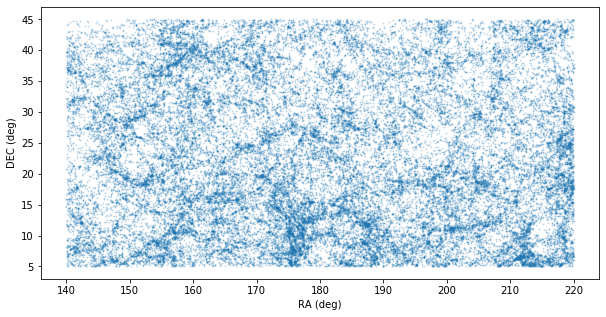

In [184]:
pl.figure(figsize=(10,5))
pl.scatter(data['ra'],data['dec'],s=1,alpha=0.2);
pl.xlabel('RA (deg)')
pl.ylabel('DEC (deg)')

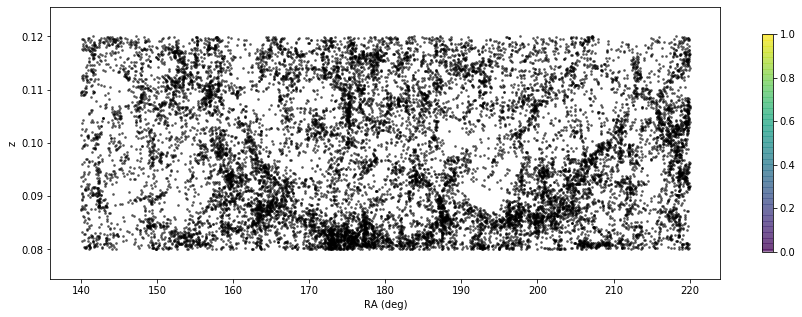

In [318]:
fig = pl.figure(figsize=(15,5))
ax = fig.gca()
_ = (data['dec'] > 10) & (data['dec'] < 20)
c = ax.scatter(data['ra'][_],data['z'][_],s=3,alpha=0.5,c='k');
pl.colorbar(c,shrink=0.8);
pl.xlabel('RA (deg)')
pl.ylabel('z');


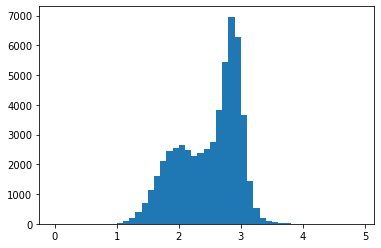

In [297]:
pl.hist(ur,bins=np.arange(0,5,0.1));

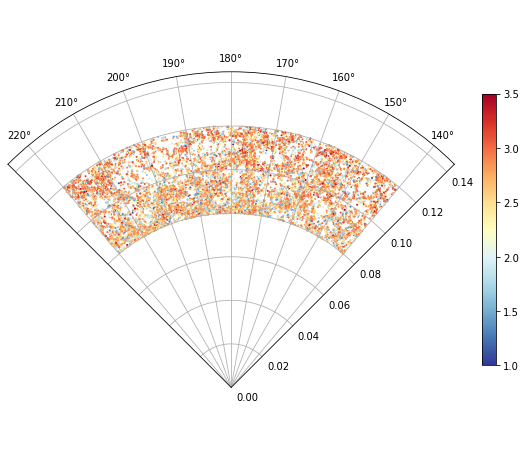

In [295]:
fig = pl.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='polar')
c   = ax.scatter(np.deg2rad(data['ra'][_]), data['z'][_],s=1,c=ur[_],alpha=1,cmap='RdYlBu_r',vmin=1.0,vmax=3.5)
ax.set_theta_zero_location('S')
ax.set_thetamin(135)
ax.set_thetamax(225)
pl.colorbar(c,shrink=0.5);

In [68]:
import time
from astroML.utils.decorators import pickle_results
from astroML.correlation import bootstrap_two_point_angular

# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functions.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

t0 = time.time()
(bins, r_corr, r_corr_err, r_bootstraps, b_corr, b_corr_err, b_bootstraps) = compute_results()
print('Time taken: {}s'.format(time.time()-t0))

@pickle_results: computing results and saving to 'correlation_functions.pkl'
Time taken: 108.19963502883911s


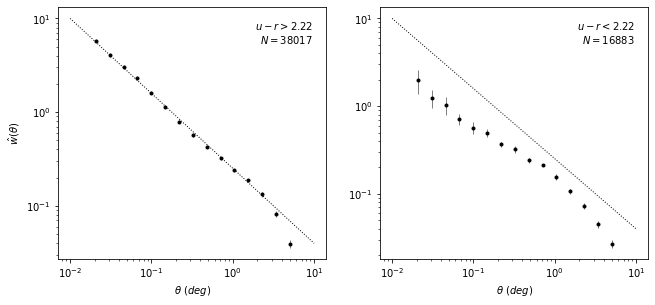

In [71]:
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = pl.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')

In [ ]:
# Compare these L-S estimator results with the standard estimator

In [80]:
@pickle_results("correlation_functions_standard.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='standard', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

t0 = time.time()
(s_bins, s_r_corr, s_r_corr_err, s_r_bootstraps, s_b_corr, s_b_corr_err, s_b_bootstraps) = compute_results()
print('Time taken: {}s'.format(time.time()-t0))

@pickle_results: computing results and saving to 'correlation_functions_standard.pkl'
Time taken: 77.94417476654053s


In [155]:
# Define a shortcut for overplotting on the same figure

def plot_corr_results(bins, corr, corr_err, bootstraps, labels=None, kwargs=None):
    """
    """
    fig = pl.gcf()
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    for i in range(len(corr)):
        ax = fig.axes[i]
            
        _kwargs = dict(fmt='.k', ecolor='gray', lw=1)
        if kwargs is not None:
            _kwargs.update(kwargs)
        ax.errorbar(bin_centers, corr[i], corr_err[i],**_kwargs)

        t = np.array([0.01, 10])
        ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

        if labels is not None:
            ax.text(0.95, 0.95, labels[i],
                    ha='right', va='top', transform=ax.transAxes)
        ax.set_xlabel(r'$\theta\ (deg)$')
        if i == 0:
            ax.set_ylabel(r'$\hat{w}(\theta)$')
    return

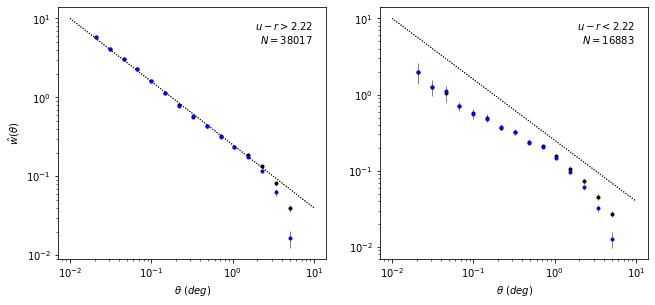

In [153]:
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = pl.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)
for i in range(len(corr)):
        ax = fig.add_subplot(121 + i, xscale='log', yscale='log')
plot_corr_results(bins, corr, corr_err, bootstraps, labels=labels) 

corr = [s_r_corr, s_b_corr]
corr_err = [s_r_corr_err, s_b_corr_err]
bootstraps = [s_r_bootstraps, s_b_bootstraps]
kwargs = {'fmt':'.b'}
plot_corr_results(bins, corr, corr_err, bootstraps,kwargs=kwargs) 


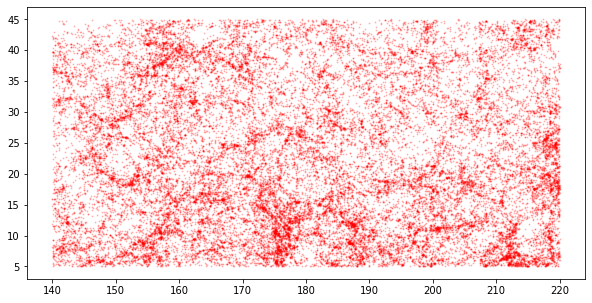

In [177]:
pl.figure(figsize=(10,5))
pl.scatter(data_red['ra'],data_red['dec'],s=1,alpha=0.2,c='r');

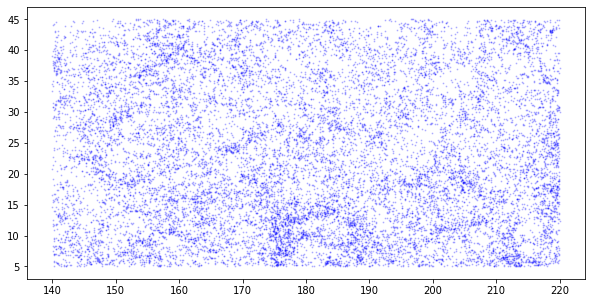

In [178]:
pl.figure(figsize=(10,5))
pl.scatter(data_blue['ra'],data_blue['dec'],s=1,alpha=0.2,c='b');

In [169]:
random_red = np.argsort(np.random.random(len(data_red)))[::5]
random_blue = np.argsort(np.random.random(len(data_blue)))[::5]
print(len(random_red),len(random_blue))

7604 3377


In [332]:
@pickle_results("correlation_functions_l.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        _ = D['ra'] < 180.0
        results += bootstrap_two_point_angular(D['ra'][_],
                                               D['dec'][_],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

t0 = time.time()
corr_l = compute_results()
print('Time taken: {}s'.format(time.time()-t0))


@pickle_results: computing results and saving to 'correlation_functions_l.pkl'
Time taken: 54.20643663406372s


In [333]:
@pickle_results("correlation_functions_r.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        _ = D['ra'] > 180.0
        results += bootstrap_two_point_angular(D['ra'][_],
                                               D['dec'][_],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

t0 = time.time()
corr_r = compute_results()
print('Time taken: {}s'.format(time.time()-t0))

@pickle_results: computing results and saving to 'correlation_functions_r.pkl'
Time taken: 50.01255917549133s


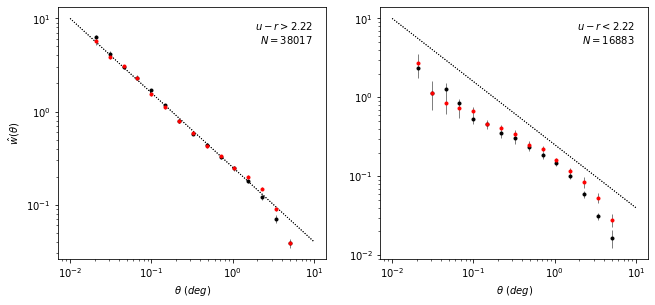

In [335]:
# Plot the results
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = pl.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(len(corr)):
        ax = fig.add_subplot(121 + i, xscale='log', yscale='log')
        
_X = corr_r
plot_corr_results(_X[0], [_X[1],_X[4]], [_X[2],_X[5]], [_X[3],_X[6]], labels=labels) 

kwargs = {'fmt':'.r'}
_X = corr_l
plot_corr_results(_X[0], [_X[1],_X[4]], [_X[2],_X[5]], [_X[3],_X[6]], kwargs=kwargs)

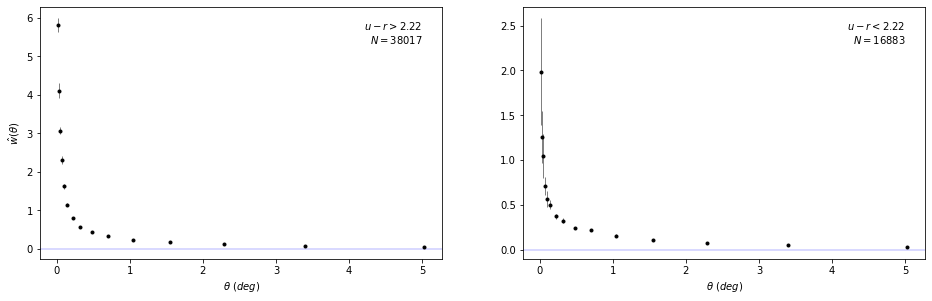

In [334]:
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = pl.figure(figsize=(15, 5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i)

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='gray', lw=1)

    pl.axhline(0,c='b',alpha=0.2)
    
    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')

In [ ]:
@pickle_results("correlation_functions_left.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [(data_red), (data_blue,random_blue)]:
        results += bootstrap_two_point_angular(D[0]['ra'][D[1]],
                                               D[0]['dec'][D[1]],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

t0 = time.time()
cr_left = compute_results()
print('Time taken: {}s'.format(time.time()-t0))

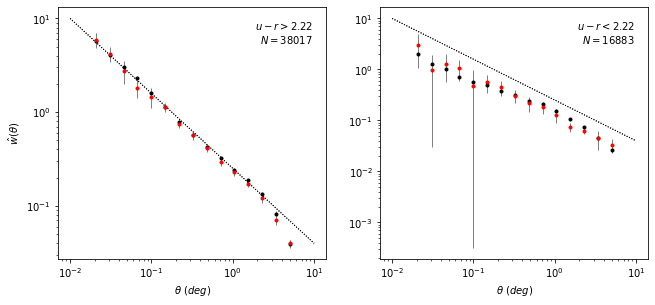

In [175]:
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = pl.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)
for i in range(len(corr)):
        ax = fig.add_subplot(121 + i, xscale='log', yscale='log')
plot_corr_results(bins, corr, corr_err, bootstraps, labels=labels) 

corr = [sp_r_corr, sp_b_corr]
corr_err = [sp_r_corr_err, sp_b_corr_err]
bootstraps = [sp_r_bootstraps, sp_b_bootstraps]
kwargs = {'fmt':'.r'}
plot_corr_results(bins, corr, corr_err, bootstraps,kwargs=kwargs) 

### Other resources

https://sites.google.com/umich.edu/mcmahoncosmology/cmb-school

http://www.astro.ubc.ca/people/jvw/ASTROSTATS/pracstats_web_ed2.html

http://learn.astropy.org/rst-tutorials/redshift-plot.html?highlight=filtertutorials
(also http://learn.astropy.org/ in general)

https://halotools.readthedocs.io/ 